In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries and tools

In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

Loading Datasets

In [3]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Testing'

# Loading and shuffling the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Loading and shuffling the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Data Visualization

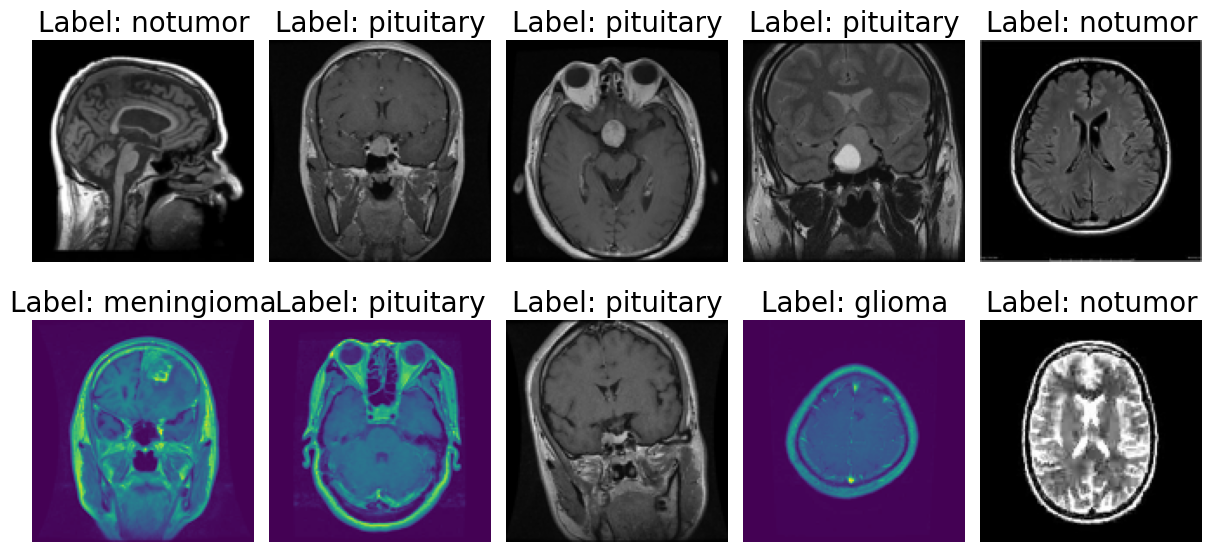

In [4]:
import matplotlib.pyplot as plt

# Selecting random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

#Creating figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#Loop through random indices to display the images
for i, index in enumerate(random_indices):
  img_path = train_paths[index]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  # Display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label: {train_labels[index]}", fontsize = 20)

plt.tight_layout()
plt.show()

Image Preprocessing

In [5]:
#Image Augmentation
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
  image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
  return image

#Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
      image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
      image = augment_image(image)
      images.append(image)
  return np.array(images)

#Encoder labels (Convert label names to integers)
def encode_label(labels):
  unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

#Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
      for i in range(0, len(paths), batch_size):
          batch_paths = paths[i:i + batch_size]
          batch_images = open_images(batch_paths)  # Open and augment images
          batch_labels = labels[i:i + batch_size]
          batch_labels = encode_label(batch_labels)  # Encode labels
          yield batch_images, batch_labels  # Yield the batch

**VGG16 MODEL FOR TRANSFER LEARNING**

In [6]:
#Model Architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#Freeze all layers on the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

#Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization

model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization

model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 1307s 5s/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7511
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - loss: 0.2755 - sparse_categorical_accuracy: 0.8924
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9364
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9549
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9734
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9676
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9777
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9873
Epoch 9/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.0358 - sparse_categor

Train and Val Plots

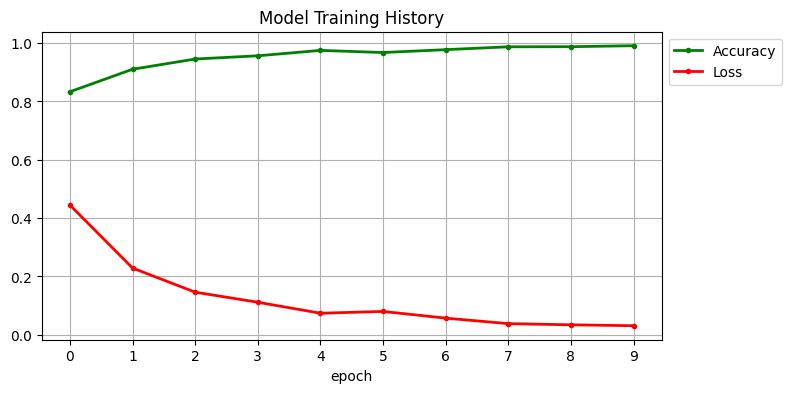

In [7]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Model Classification Report

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.97      0.95      0.96       300
           2       0.98      0.99      0.99       300
           3       0.95      0.96      0.95       306

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix:
[[404   0   1   0]
 [  0 285   2  13]
 [  0   1 297   2]
 [  1   9   3 293]]


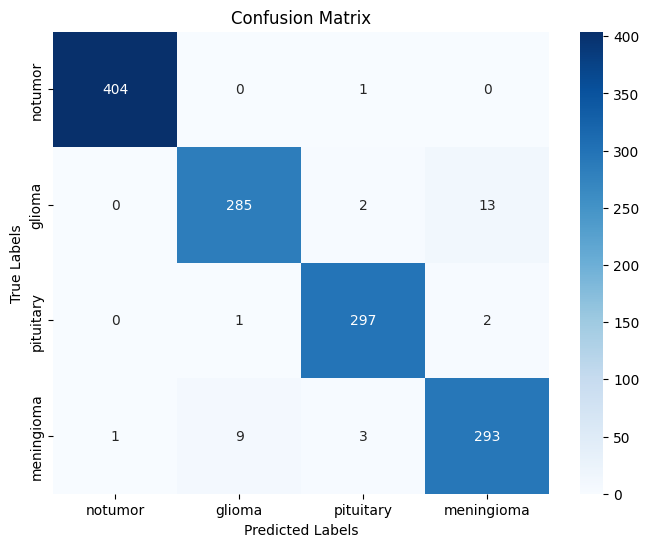

In [9]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Roc Curve Plot

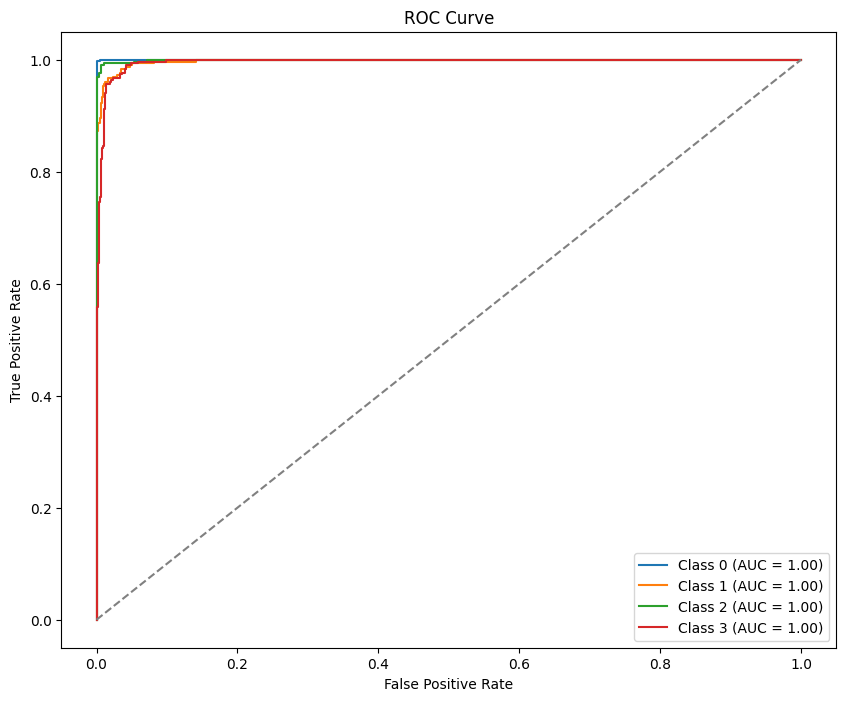

In [10]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Save and Load the model

In [11]:
model.save('model.h5')

In [12]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

#**Brain Tumor Detection System**

In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['notumor', 'glioma', 'pituitary', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
  try:
      # Load and preprocess the image
      img = load_img(img_path, target_size=(image_size, image_size))
      img_array = img_to_array(img) / 255.0  # Normalize pixel values
      img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

      # Make a prediction
      predictions = model.predict(img_array)
      predicted_class_index = np.argmax(predictions, axis=1)[0]
      confidence_score = np.max(predictions, axis=1)[0]

      # Determine the class
      if class_labels[predicted_class_index] == 'notumor':
          result = "No Tumor"
      else:
          result = f"Tumor: {class_labels[predicted_class_index]}"

      # Display the image with the prediction
      plt.imshow(load_img(img_path))
      plt.axis('off')
      plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
      plt.show()

  except Exception as e:
      print("Error processing the image:", str(e))

Example

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


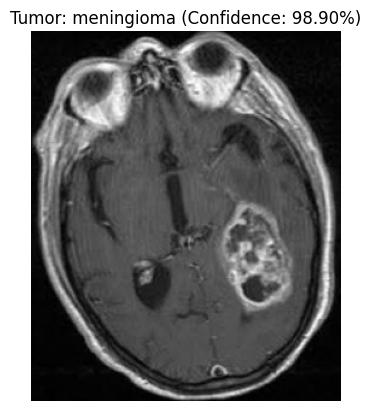

In [14]:
image_path = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


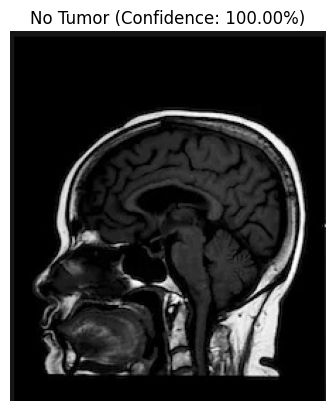

In [15]:
image_path = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Testing/notumor/Te-noTr_0004.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


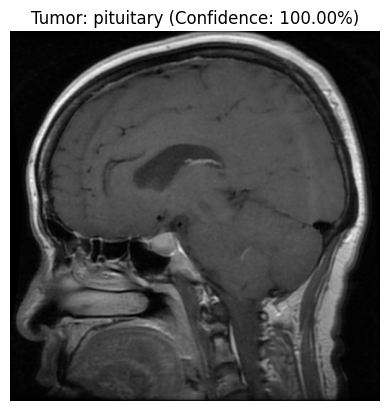

In [16]:
image_path = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


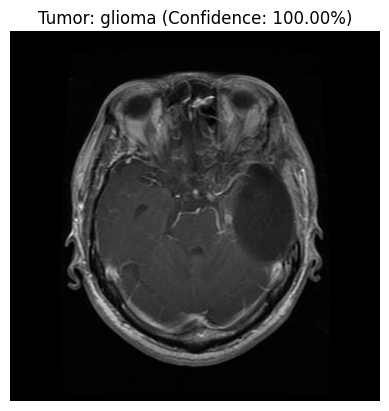

In [17]:
image_path = '/content/drive/MyDrive/Colab Notebooks/MRI Images/Testing/glioma/Te-gl_0015.jpg'
detect_and_display(image_path, model)